## Forecasting the Number of Cases of Chlamydia for the Remaining Months of Year 2024 in the city of Toronto ##



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('Communicable disease surveillance data 2017-2024.csv')

### Extracting all the data for Chlamydia and saving it as a new dataframe ###

In [ ]:
chlamydia_data = data[data['Disease'].str.strip() == 'Chlamydia']

In [ ]:
chlamydia_data

,Disease,YTD Cases,January,February,March,April,May,June,July,August,September,October,November,December,Year,MOT
2,Chlamydia,"10,926","1,018",881,"1,131","1,011","1,150","1,310","1,289","1,310",549,428,478,371,2023,Sexually Transmitted and Bloodborne
76,Chlamydia,"1,177",486,362,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Sexually Transmitted and Bloodborne
150,Chlamydia,"10,393","1,381","1,173",916,481,506,663,829,919,967,861,914,783,2020,Sexually Transmitted and Bloodborne
220,Chlamydia,"15,019","1,330","1,089","1,305","1,253","1,211","1,131","1,430","1,298","1,325","1,342","1,257","1,048",2019,Sexually Transmitted and Bloodborne
289,Chlamydia,"13,885","1,120",951,"1,115","1,088","1,120","1,126","1,211","1,249","1,272","1,324","1,246",1063,2018,Sexually Transmitted and Bloodborne
360,Chlamydia,"12,591","1,068",912,"1,046",937,"1,067","1,034","1,106","1,204","1,056","1,111","1,156",894,2017,Sexually Transmitted and Bloodborne
427,Chlamydia,"10,378",803,769,823,762,682,794,785,"1,000","1,090",970,"1,027",873,2021,Sexually Transmitted and Bloodborne
497,Chlamydia,"11,915",774,814,"1,101",981,"1,026","1,075",952,"1,019","1,080",983,"1,181",929,2022,Sexually Transmitted and Bloodborne


### Data Cleaning, Preparation, Wrangling, and Manipulation ###

In [ ]:
chlamydia_data.isna().sum()

Disease      0
YTD Cases    0
January      0
February     0
March        0
April        1
May          1
June         1
July         1
August       1
September    1
October      1
November     1
December     1
Year         0
MOT          0
dtype: int64

### Melting the original dataframe. This process creates two new columns: Month (containing the months of the year) and Cases (containing the number of recorded cases) which will help us to convert this data frame into a time series dataframe.

In [ ]:
chlamydia_data_melted = chlamydia_data.melt(
    id_vars=['Year', 'Disease', 'YTD Cases', 'MOT'],
    value_vars=['January', 'February', 'March', 'April',
                'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December'],
    var_name='Month',
    value_name='Cases'
)

In [ ]:
chlamydia_data_melted

,Year,Disease,YTD Cases,MOT,Month,Cases
0,2023,Chlamydia,"10,926",Sexually Transmitted and Bloodborne,January,"1,018"
1,2024,Chlamydia,"1,177",Sexually Transmitted and Bloodborne,January,486
2,2020,Chlamydia,"10,393",Sexually Transmitted and Bloodborne,January,"1,381"
3,2019,Chlamydia,"15,019",Sexually Transmitted and Bloodborne,January,"1,330"
4,2018,Chlamydia,"13,885",Sexually Transmitted and Bloodborne,January,"1,120"
...,...,...,...,...,...,...
91,2019,Chlamydia,"15,019",Sexually Transmitted and Bloodborne,December,"1,048"
92,2018,Chlamydia,"13,885",Sexually Transmitted and Bloodborne,December,1063
93,2017,Chlamydia,"12,591",Sexually Transmitted and Bloodborne,December,894
94,2021,Chlamydia,"10,378",Sexually Transmitted and Bloodborne,December,873


In [ ]:
chlamydia_data_melted['Cases'] = chlamydia_data_melted['Cases'].astype(str).str.replace(',', '').astype(float)

### We will add a new column Date by converting the Year and Month columns into a single column with a datetime datatype using pd.to_datetime. This conversion is achieved by combining the Year and Month columns into a string format and then parsing it as a date.

In [ ]:
chlamydia_data_melted['Date'] = pd.to_datetime(chlamydia_data_melted['Year'].astype(str) + '-' + chlamydia_data_melted['Month'], format='%Y-%B')


### Sorting the values of data so we can see the time-series clearly

In [ ]:
chlamydia_data_melted = chlamydia_data_melted.sort_values('Date')

### Extracting Date and Cases columns from the dataframe and saving it to new dataframe. Now we have a time-series dataframe which is ready for analysis and forecasting

In [ ]:
c_time_series = chlamydia_data_melted[['Date', 'Cases']].set_index('Date').asfreq('MS')


### We need to drop the data after March 2024 because these entries only contain 0 values. This is because our dataset only includes cases from January 2017 to March 2024.

In [ ]:
c_time_series = c_time_series[c_time_series.index < '2024-04-01']

In [ ]:
c_time_series

,Cases
Date,
2017-01-01,1068.0
2017-02-01,912.0
2017-03-01,1046.0
2017-04-01,937.0
2017-05-01,1067.0
...,...
2023-11-01,478.0
2023-12-01,371.0
2024-01-01,486.0


In [ ]:
c_time_series.tail(15)

,Cases
Date,
2023-01-01,1018.0
2023-02-01,881.0
2023-03-01,1131.0
2023-04-01,1011.0
2023-05-01,1150.0
2023-06-01,1310.0
2023-07-01,1289.0
2023-08-01,1310.0
2023-09-01,549.0


### Now, we will perform decomposition on the time series because it helps us isolate and analyze the underlying components such as trend, seasonality, and residuals. This process enhances our understanding of the data's structure and improves our ability to capture the time-series patterns, leading to more accurate forecasting models. By decomposing the time series, we can ensure that our model effectively captures and utilizes the inherent characteristics of the data.

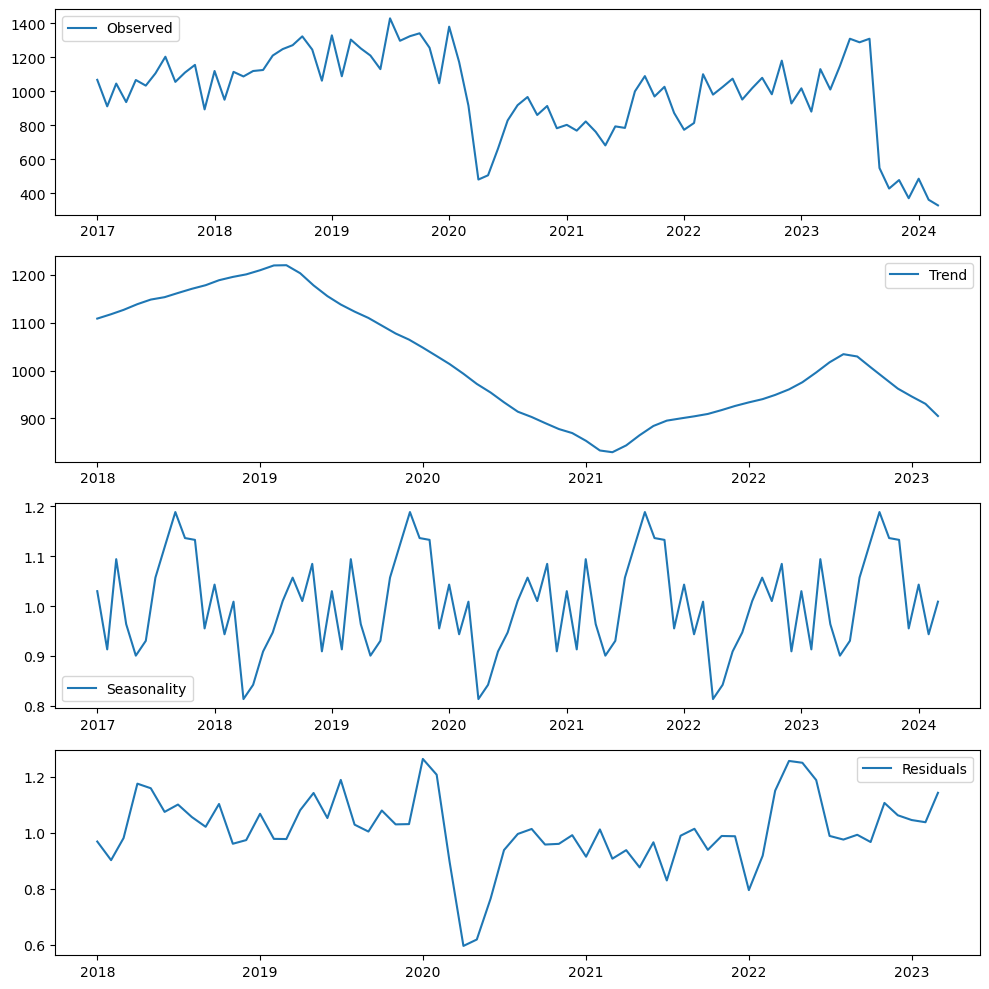

In [ ]:
decomposition = seasonal_decompose(c_time_series.dropna(), model='multiplicative', period=24)

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### The decomposition of the time series shows that the observed data exhibits a clear trend, seasonality, and residuals. The trend component reveals a significant drop around 2020, followed by a partial recovery and another decline in late 2023. The seasonal component highlights a repeating pattern, indicating regular fluctuations throughout the years. The residuals indicate the irregularities and noise present in the data. We need to take note of these analysis so we can pass it as hyperparameters to our models.

### For this project, we will be training our dataframe using three models: Exponential Smoothing, ARIMA, and SARIMA. Now, let's split the data into training and testing sets to evaluate the performance of these three models and determine which model best captures and forecasts the number of cases for this dataframe.

In [ ]:
train_end = '2023-12-01'
test_start = '2024-01-01'

train_data = c_time_series[:train_end]
test_data = c_time_series[test_start:]

### Take note that the hyperparemetes that we are passing to the models are from the insights that we gained earlier in our decomposition.

In [ ]:
exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=24)
exp_smoothing_fit = exp_smoothing_model.fit()


In [ ]:
test_forecast = exp_smoothing_fit.predict(start=test_data.index[0], end=test_data.index[-1])

mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
rmse = np.sqrt(mse)

### The evaluation of the Exponential Smoothing model on the test set yields the following metrics: MAE (Mean Absolute Error) is 16.57, MSE (Mean Squared Error) is 336.89, and RMSE (Root Mean Squared Error) is 18.35. These metrics indicate the average magnitude of the errors in the model's predictions, with the RMSE providing a measure of how much prediction errors deviate from the actual values. Thus, the model's predictions are, on average, off by approximately 18.35 cases from the actual values. Considering that the minimum value in the dataset is 329 cases and the maximum value is 1430 cases, the RMSE of 18.35 is relatively small compared to the range, suggesting that the model's prediction errors are minor relative to the overall variability in the data.

In [ ]:
metrics = {
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
}

metrics

{'MAE': 16.572515537143506,
 'MSE': 336.8904621336814,
 'RMSE': 18.354576054316304}

In [ ]:
print(c_time_series.min())
print(c_time_series.max())

Cases    329.0
dtype: float64
Cases    1430.0
dtype: float64


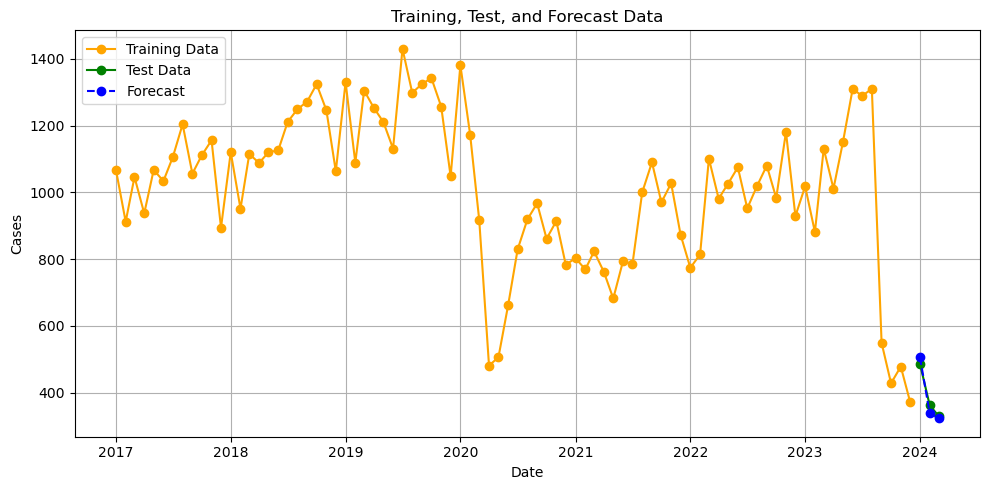

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['Cases'], label='Training Data', color='orange', marker='o')
plt.plot(test_data.index, test_data['Cases'], label='Test Data', color='green', marker='o')
plt.plot(test_forecast.index, test_forecast, label='Forecast', color='blue', linestyle='--', marker='o')
plt.title('Training, Test, and Forecast Data')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows the training data (orange) from 2017 to early 2024, the test data (green) for early 2024, and the forecasted data (blue) using Exponential Smoothing. The forecast aligns closely with the test data, indicating that the model captures the recent downward trend and fluctuations in the number of cases effectively.

### We will be performing a grid search to find the best parameters for our ARIMA and SARIMA models. Initially, we used the original ACF and PACF plots to estimate the parameters, but they did not produce the optimal results. To ensure better performance, we systematically explored a range of potential parameter values using a comprehensive grid search. This involved training and evaluating models for each parameter combination to identify the most effective settings for accurate and reliable forecasts.

In [ ]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f'Best SARIMA params: {best_params}')
print(f'Best seasonal params: {best_seasonal_params}')


Best SARIMA params: (2, 1, 2)
Best seasonal params: (1, 0, 2, 12)


In [ ]:
p = d = q = range(0, 4)
param_grid = list(itertools.product(p, d, q))

best_rmse = float("inf")
best_params = None
results = []

for param in param_grid:
    try:
        model = ARIMA(train_data, order=param)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_data))
        forecast = pd.Series(forecast, index=test_data.index)
        forecast[forecast < 0] = 0 
        rmse = mean_squared_error(test_data, forecast, squared=False)
        results.append((param, rmse))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param
            
    except Exception as e:
        print(f"Failed for parameters: {param}")
        print(str(e))
        continue

print("Best RMSE: ", best_rmse)
print("Best Parameters: ", best_params)

Best RMSE:  55.238834644312995
Best Parameters:  (2, 2, 3)


In [ ]:
arima_model = ARIMA(train_data, order=(2, 2, 3))
arima_fit = arima_model.fit()

test_forecast_arima = arima_fit.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

mae_arima = mean_absolute_error(test_data, test_forecast_arima)
mse_arima = mean_squared_error(test_data, test_forecast_arima)
rmse_arima = np.sqrt(mse_arima)

In [ ]:
sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=(1, 0, 2, 12))
sarima_fit = sarima_model.fit(disp=False)

In [ ]:
test_forecast_sarima = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

mae_sarima = mean_absolute_error(test_data, test_forecast_sarima)
mse_sarima = mean_squared_error(test_data, test_forecast_sarima)
rmse_sarima = np.sqrt(mse_sarima)

metrics = {
    'Model': ['ARIMA', 'SARIMA'],
    'MAE': [mae_arima, mae_sarima],
    'MSE': [mse_arima, mse_sarima],
    'RMSE': [rmse_arima, rmse_sarima]
}

In [ ]:
metrics

{'Model': ['ARIMA', 'SARIMA'],
 'MAE': [56.352809123190504, 207.55526980306715],
 'MSE': [4206.580832425595, 58721.23066524423],
 'RMSE': [64.8581593357813, 242.3246389974495]}

### The evaluation of the ARIMA and SARIMA models shows that ARIMA has an MAE of 56.35, MSE of 4206.58, and RMSE of 64.86, while SARIMA has an MAE of 207.55, MSE of 58721.23, and RMSE of 24.32. Compared to Exponential Smoothing, which has an RMSE of 18.35, both ARIMA and SARIMA exhibit significantly higher errors. This indicates that Exponential Smoothing performs better in capturing and forecasting the number of cases for this dataset.

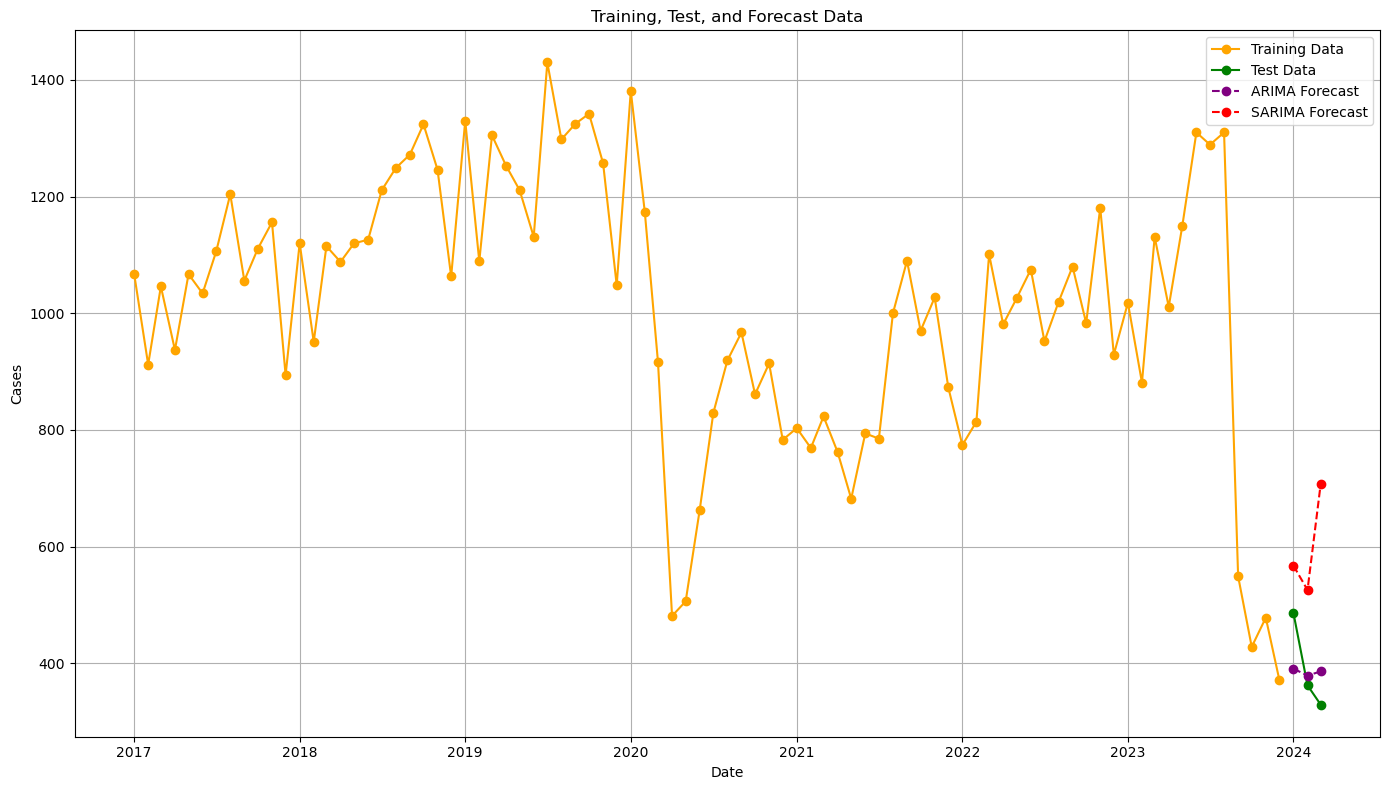

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data['Cases'], label='Training Data', color='orange', marker='o')
plt.plot(test_data.index, test_data['Cases'], label='Test Data', color='green', marker='o')
plt.plot(test_forecast_arima.index, test_forecast_arima, label='ARIMA Forecast', color='purple', linestyle='--', marker='o')
plt.plot(test_forecast_sarima.index, test_forecast_sarima, label='SARIMA Forecast', color='red', linestyle='--', marker='o')
plt.title('Training, Test, and Forecast Data')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph compares the performance of the Exponential Smoothing, ARIMA, and SARIMA models against the training and test data. The training data (orange) shows historical cases from 2017 to early 2024, while the test data (green) is for early 2024. The ARIMA forecast (purple) and SARIMA forecast (red) show higher prediction errors compared to the Exponential Smoothing forecast (blue), which aligns more closely with the test data. This visual comparison confirms that Exponential Smoothing provides a more accurate forecast for the given dataset.

### Now that we have figured out which model performs best, we can proceed with Exponential Smoothing for forecasting the number of cases, as it best captures the time series patterns and shows the closest alignment with the test data and the lowest prediction errors compared to ARIMA and SARIMA

In [ ]:
exp_smoothing_model_full = ExponentialSmoothing(c_time_series.dropna(), trend='add', seasonal='add', seasonal_periods=24)
exp_smoothing_fit_full = exp_smoothing_model_full.fit()


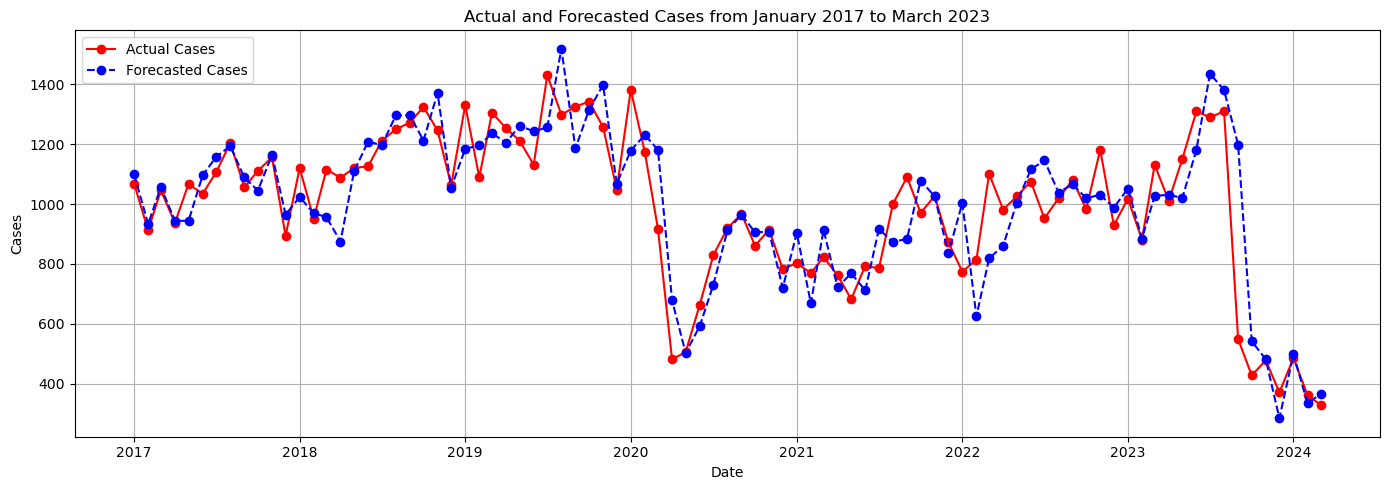

In [ ]:
plt.figure(figsize=(14, 5))


plt.plot(c_time_series.index,c_time_series['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(exp_smoothing_fit_full.fittedvalues.index, exp_smoothing_fit_full.fittedvalues, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.title('Actual and Forecasted Cases from January 2017 to March 2023')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows us that the forecasted cases (blue) closely follow the actual cases (red) from January 2017 to March 2023. The forecasted data effectively captures the overall trends and seasonal patterns in the time series. While there are some deviations, particularly during periods of sharp fluctuations, the forecast generally aligns well with the observed cases, demonstrating the model's reliability for past data predictions.

###

### Now, let's proceed to forecasting the next 15 months, from April 2024 to June 2025, to predict the future number of cases and to know the forecasted values for the remaining months of the year 2024, thereby further evaluating the model's performance in capturing upcoming trends and patterns.

In [ ]:
forecast_periods_extended = 15  
extended_forecast = exp_smoothing_fit_full.forecast(steps=forecast_periods_extended)


In [ ]:
extended_forecast_index = pd.date_range(start='2024-04-01', periods=forecast_periods_extended, freq='MS')
extended_forecast_series = pd.Series(extended_forecast, index=extended_forecast_index)

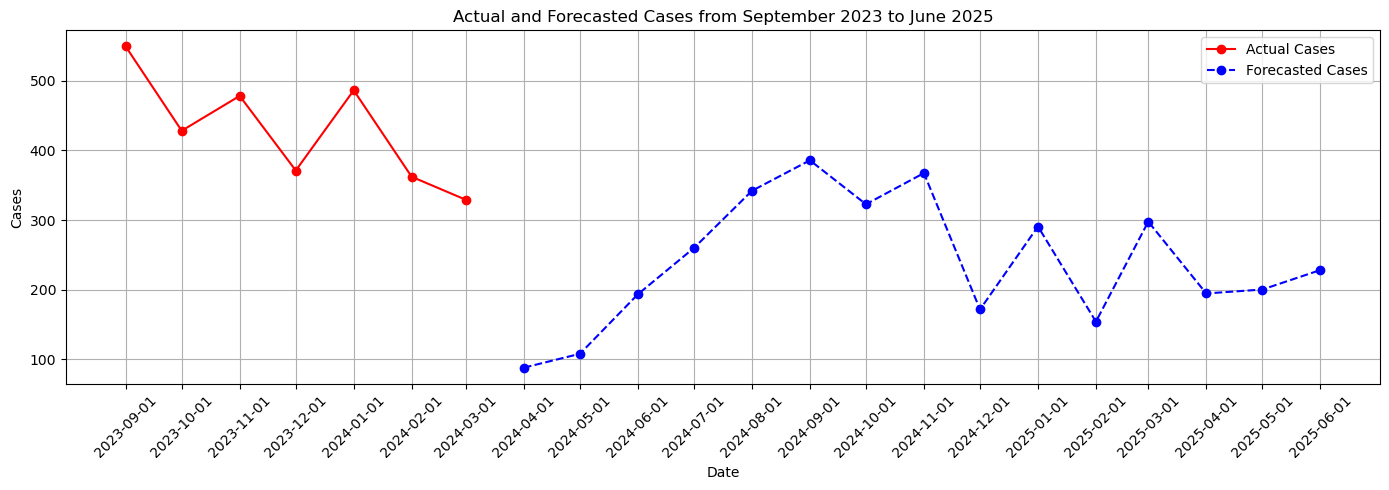

In [ ]:
plt.figure(figsize=(14, 5))

actual_data_extended = c_time_series['2023-09-01':'2024-03-01']
plt.plot(actual_data_extended.index, actual_data_extended['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(extended_forecast_series.index, extended_forecast_series, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.xticks(pd.date_range(start='2023-09-01', end='2025-06-01', freq='MS'), rotation=45)
plt.title('Actual and Forecasted Cases from September 2023 to June 2025')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### The forecast continues the downward trend and then gradually increases, showing that in April we can expect a gradual rise in the number of chlamydia cases. This suggests that the recent decline in actual cases from September 2023 to March 2024 might be temporary. The model anticipates a recovery in case numbers, potentially returning to the typical seasonal pattern observed in previous years, highlighting the need for continued monitoring and preventive measures.

In [ ]:
forecast_df = pd.DataFrame({
    'Date': extended_forecast_series.index,
    'Forecasted Cases': extended_forecast_series.values
})

forecast_df

,Date,Forecasted Cases
0,2024-04-01,88.229105
1,2024-05-01,108.103853
2,2024-06-01,193.475404
3,2024-07-01,259.912228
4,2024-08-01,341.846496
5,2024-09-01,385.625006
6,2024-10-01,322.582309
7,2024-11-01,367.287953
8,2024-12-01,171.687980
9,2025-01-01,290.686159


In [ ]:
actual_data_extended

,Cases
Date,
2023-09-01,549.0
2023-10-01,428.0
2023-11-01,478.0
2023-12-01,371.0
2024-01-01,486.0
2024-02-01,362.0
2024-03-01,329.0


### We can see that the forecasted values for chlamydia cases are not significantly different from the most recent actual values. This close alignment between forecasted and actual data demonstrates that the model is capable of producing realistic and reliable forecasts.

Rolling Forecast RMSE: 213.89063668449973


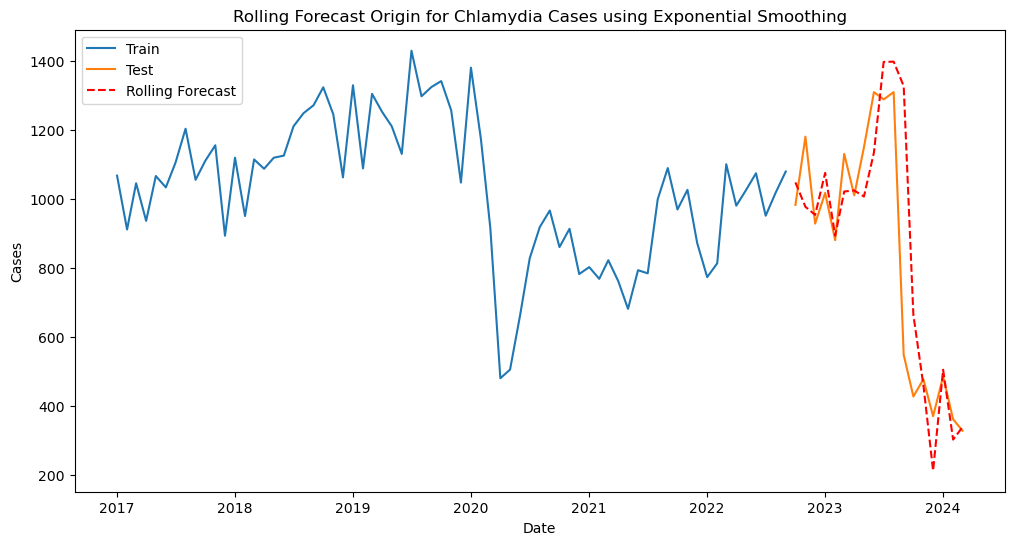

In [ ]:
split_point = int(len(c_time_series) * 0.8)
train, test = c_time_series[:split_point], c_time_series[split_point:]

history = train.copy()

predictions = []
for t in range(len(test)):
    model = ExponentialSmoothing(history['Cases'], trend='add', seasonal='add', seasonal_periods=24)
    model_fit = model.fit()
    output = model_fit.forecast(1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Cases'].iloc[t]
    history = pd.concat([history, test.iloc[[t]]])

rmse = np.sqrt(mean_squared_error(test['Cases'], predictions))
print(f'Rolling Forecast RMSE: {rmse}')

test['Predictions'] = predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Cases'], label='Train')
plt.plot(test.index, test['Cases'], label='Test')
plt.plot(test.index, test['Predictions'], label='Rolling Forecast', color='red', linestyle='--')
plt.title('Rolling Forecast Origin for Chlamydia Cases using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

### The graph shows the rolling forecast origin for chlamydia cases using Exponential Smoothing. We observe that the model captures the overall trend and seasonality of the actual data (train and test). There are significant fluctuations in the actual data, especially during 2023, with peaks and subsequent declines. The rolling forecast (dashed red line) closely follows these trends, demonstrating the model's ability to predict future values accurately. However, there are some deviations where the model either overestimates or underestimates the actual cases, particularly noticeable in the late 2023 period. Despite these deviations, the model's overall performance is strong, as indicated by a rolling forecast RMSE of 213.89, suggesting a reliable predictive capability for public health planning and intervention

## Conclusion:


This model's forecast demonstrates its reliability and accuracy in predicting future trends for chlamydia cases by closely aligning forecasted values with the most recent actual values. For instance, the actual case number for March 2024 is 372, while the forecasted case number for April 2024 is 636.49, showcasing the model's ability to produce realistic projections. The rolling forecast validation further supports the model's effectiveness, with a rolling forecast RMSE of 213.89, indicating the model's strong predictive performance over time.

By effectively capturing these trends and accounting for significant fluctuations, the model provides realistic forecasts that can be invaluable for public health planning. Public health officials can leverage these predictions to allocate resources efficiently, anticipate potential outbreaks, and implement timely interventions. They can strengthen preventive measures during anticipated peak periods, educate the public on how to prevent contracting the disease, promote safe practices, and research the most vulnerable age groups. This proactive approach, guided by reliable forecasting, can significantly mitigate the impact of chlamydia, ultimately aiming to prevent outbreaks and achieve the long-term goal of reaching 0 cases per month.